In this experiment section, we want to answer to 3 main questions: 

- Do new features increase the performance of a classifier?
    --> the difference of the performance are statistically significant? 
- Which is the best set of features among the ones described above?
    --> Description of the remanining features, what they focus on?
- Which are the characteristics of the best classifier? 
    - Feature importance
    - Probability distribution 
    - Classification explanation
    - Errors study

Are the features proposed in [3] valid set of features if we consider a larger set of smart-contracts?

We consider the set of smart contracts as the union of the smart contracts made available in the papers [1,2,3] and we evaluate the performance of several classifiers tuning their hyperparameters by means of a grid search and k-fold cross validation procedure. Grid search tests all the possible combinations of values of hyperparameters given in input to the classifier. The k-fold cross validation, instead, splits the training dataset in k folds, and performs the training of the configured classifier on k-1 folds and uses the k-th fold as validation set. Then, the folds are permuted so that everyone is used as validation set. 





In [76]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
# import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import shap
import lightgbm as lgb
import glob
from sklearn.feature_selection import RFE


[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; t

In [2]:
plt.rcParams["mathtext.fontset"]

'dejavusans'

In [3]:
plt.rcParams.update({'font.size': 28, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr, auc_score,label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.title('AUC Score: {}'.format(auc_score))
    plt.grid(True)                                            
    plt.show()


In [5]:
def best_classifiers_cv(df_cv,data,X_train,y_train,X_test,y_test):
    df_cv['classifier'] = df_cv.param_classifier.apply(lambda x: x.__str__().split('(')[0])
    df_cv['ranking_by_classifier'] = df_cv.sort_values(by='rank_test_score').groupby(['classifier'])['rank_test_score'].cumcount() + 1
    for row in df_cv[df_cv['ranking_by_classifier']==1].iterrows():
        cls = row[1]['param_classifier']
        name_classifier = row[1]['classifier'] 
        print(row[1]['classifier'])
        cls.fit(X_train,y_train.ravel())
        y_pred_train = cls.predict(X_train)
        data['precision_training_{}'.format(name_classifier)] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
        data['recall_training_{}'.format(name_classifier)] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
        data['accuracy_training_{}'.format(name_classifier)] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
        data['f1_training_{}'.format(name_classifier)] = [f1_score(y_train, y_pred_train)]    

        # Confusion matrix 
        y_pred = cls.predict(X_test)
        data['precision_test_{}'.format(name_classifier)] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
        data['recall_test_{}'.format(name_classifier)] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
        data['accuracy_test_{}'.format(name_classifier)] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
        data['f1_test_{}'.format(name_classifier)] = [f1_score(y_test, y_pred)]

        y_pred_proba = cls.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
        auc_score = roc_auc_score(y_test,y_pred_proba)

        data['auc_score_test_{}'.format(name_classifier)] = auc_score

#         plt.figure(figsize=(8, 6))                                    
#         plot_roc_curve(fpr, tpr, auc_score)


In [19]:
def get_grid_search(dataset,name):
    data = {}
    data['test'] = name
    X = dataset.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
    y = dataset.loc[:, ['target']].values

    print(dataset.target.value_counts())
    print(X.shape,y.shape,dataset.columns)

    # divido in train set (TR) e test set (TS)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

    flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
    print('Number of smart contract in train set::', flat_list_train.count(0))
    print('Number of smart Ponzi in train set::', flat_list_train.count(1))
    flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
    print('Number of smart contract in test set::', flat_list_test.count(0))
    print('Number of smart Ponzi in test set::', flat_list_test.count(1))
    pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

    params =[
        {
            'classifier': [DecisionTreeClassifier(random_state=42)],
            'classifier__criterion' : ['entropy', 'gini'],
            'classifier__max_depth' : [5, 6, 7, 8, 9],
            'classifier__min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
            'classifier__max_features' : range(6,X_train.shape[1],3),
            'classifier__class_weight' : [{0:1, 1:4}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
        },
        {
            'classifier': [RandomForestClassifier(random_state=42)],
            'classifier__n_estimators':[150, 175, 200, 225, 250],
            'classifier__min_samples_split' : [5,15,30],
            'classifier__criterion':['gini', 'entropy'],
            'classifier__class_weight' : [{0:1, 1:5.5}],
            'classifier__bootstrap': [True, False]
        },
    #     {
    #         'classifier': [SVC(random_state=42,probability=True)],            
    #         'classifier__kernel' : ["poly"],
    #         'classifier__C' : [0.1,1,5,10],
    #         'classifier__coef0' : [1,0.8],
    #         'classifier__gamma': ['auto']

    #     },
        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1,0.01],
            'classifier__n_estimators' : [80, 100, 120],
            'classifier__max_depth' : [10,15,20],
            'classifier__colsample_bytree' : [0.5,0.8,1],
            'classifier__reg_alpha' : [0, 0.1, 0.2],
            'classifier__reg_lambda' : [1,10,15]
        }



         ]
    grid_search = GridSearchCV(pipeline, params, cv=5,
                               scoring='roc_auc',
                               return_train_score=True,n_jobs=4,verbose=2)
    grid_search.fit(X_train, y_train.ravel())
    df_cv = pd.DataFrame(grid_search.cv_results_)
    best_classifiers_cv(df_cv,data,X_train,y_train,X_test,y_test)
    
    data['best hyperparameters'] = [grid_search.best_params_]
    data['best score'] = [grid_search.best_score_]

    y_pred_train = grid_search.best_estimator_.predict(X_train)
    data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
    data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
    data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
    data['best_f1_training'] = [f1_score(y_train, y_pred_train)]    

    # Confusion matrix 
    y_pred = grid_search.best_estimator_.predict(X_test)
    data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
    data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
    data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
    data['best_f1_test'] = [f1_score(y_test, y_pred)]
    return grid_search,data

In [20]:
features_dataset_paper = ['address', 'balance', 'N_maxpayment',
                          'investment_in', 'payment_out',
                          'mean_v1', 'sdev_v1', 'skew_v1',
                          'mean_v2', 'sdev_v2', 'skew_v2',
                          'known_rate', 'paid_rate', 'paid_one','target']

In [35]:
features_dataset_full = ['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
       'payment_out', 'investment_to_contract/tx_in',
       'payment_from_contract/tx_out', '#addresses_paying_contract',
       '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2',
       'sdev_v2', 'paid_rate', 'paid_one', 'percentage_some_tx_in',
       'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'known_rate',
       'owner_gets_eth_Wo_investing', 'owner_gets_eth_investing',
       'owner_no_eth', 'skew_v1', 'N_maxpayment', 'skew_v2', 'target']

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15;

In [21]:
path = '../dataset'
dataset_path = glob.glob(path+"/dataset*.csv")[0]
dataset_paper = pd.read_csv(dataset_path, header = 0)
df_dataset_paper = dataset_paper[features_dataset_paper].copy()


In [22]:
df_dataset = df_dataset_paper.drop_duplicates(subset='address')
grid_search_paper,data_paper = get_grid_search(df_dataset,'paper')

0    3749
1     673
Name: target, dtype: int64
(4422, 13) (4422, 1) Index(['address', 'balance', 'N_maxpayment', 'investment_in', 'payment_out',
       'mean_v1', 'sdev_v1', 'skew_v1', 'mean_v2', 'sdev_v2', 'skew_v2',
       'known_rate', 'paid_rate', 'paid_one', 'target'],
      dtype='object')
Number of smart contract in train set:: 2999
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 750
Number of smart Ponzi in test set:: 135
Fitting 5 folds for each of 726 candidates, totalling 3630 fits
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, class

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), cla

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42),

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=175; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=175; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=175; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=175; total time=   0.4s
[CV] END classifier=RandomForestClassifi

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.6s
[CV] END classifier=RandomFo

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=Rand

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=250; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=250; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.5s
[CV] END classifier=RandomFo

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=225; total time=   0.9s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=250; total time=   0.8s
[CV] END classifier=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; tota

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_l

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_la

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__re

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_la

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_l

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; tot

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total ti

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; tota

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; 

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; tot

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15;

LGBMClassifier


In [42]:
df_results = pd.DataFrame(data_paper)

In [24]:
df_dataset_full.target.value_counts()

0    3749
1     673
Name: target, dtype: int64

In [38]:
path = '../dataset/'
dataset_path = glob.glob(path+"/dataset*.csv")[0]
dataset_full = pd.read_csv(dataset_path, header = 0)
df_dataset_full = dataset_full[features_dataset_full].copy()

In [39]:
df_dataset_full = df_dataset_full.drop_duplicates(subset='address')
grid_search_full, data_full = get_grid_search(df_dataset_full,'full_dataset')

0    3749
1     673
Name: target, dtype: int64
(4422, 27) (4422, 1) Index(['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
       'payment_out', 'investment_to_contract/tx_in',
       'payment_from_contract/tx_out', '#addresses_paying_contract',
       '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2',
       'sdev_v2', 'paid_rate', 'paid_one', 'percentage_some_tx_in',
       'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'known_rate',
       'owner_gets_eth_Wo_investing', 'owner_gets_eth_investing',
       'owner_no_eth', 'skew_v1', 'N_maxpayment', 'skew_v2', 'target'],
      dtype='object')
Number of smart contract in train set:: 2999
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 750
Number of smart Ponzi in test set:: 135
Fitting 5 folds for each of 966 candidates, totalling 4830 fits
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=en

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=18, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=18, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=18, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=18, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(rando

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), cla


[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), cl

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classif

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), c

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=24, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), cl

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=24, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=24, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=24, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=24, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42),

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifi

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=6, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifi

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(r

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(r

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=15, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=15, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=15, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=15, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=18, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=18, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=18, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=18, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_sta

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_sta

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=21, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=21, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_stat

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=15, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.7s
[CV] END classifier=RandomForestClassifi

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.5s
[CV] END classifier=RandomFo

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=250; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.6s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=175; total time=   0.8s
[CV] END classifier=RandomForestC

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=225; total time=   0.9s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=250; total time=   1.0s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=150; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=175; total time=   0.9s
[CV] END classifier=RandomFo

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=225; total time=   1.1s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=250; total time=   1.2s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=150; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=30, classifier__n_estimators=175; total time=   0.9s
[CV] END classifier=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; 

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_la

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; 

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_la

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total tim

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; tot

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; tota

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total 

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total ti

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1

DecisionTreeClassifier
RandomForestClassifier
LGBMClassifier


In [43]:
df_results = pd.concat([df_results,pd.DataFrame(data_full)])

In [44]:
df_results

,test,precision_training_DecisionTreeClassifier,recall_training_DecisionTreeClassifier,accuracy_training_DecisionTreeClassifier,f1_training_DecisionTreeClassifier,precision_test_DecisionTreeClassifier,recall_test_DecisionTreeClassifier,accuracy_test_DecisionTreeClassifier,f1_test_DecisionTreeClassifier,auc_score_test_DecisionTreeClassifier,...,best hyperparameters,best score,best_precision_training,best_recall_training,best_accuracy_training,best_f1_training,best_precision_test,best_recall_test,best_accuracy_test,best_f1_test
0,paper,0.994805,0.711896,0.955612,0.829902,0.558824,0.422222,0.861017,0.481013,0.674430,...,{'classifier': LGBMClassifier(colsample_bytree...,0.805108,0.984026,0.572491,0.933560,0.723854,0.714286,0.333333,0.877966,0.454545
0,full_dataset,0.993902,0.908922,0.985298,0.949515,0.529412,0.466667,0.855367,0.496063,0.733279,...,{'classifier': LGBMClassifier(colsample_bytree...,0.890530,0.980392,0.743494,0.958722,0.845666,0.783133,0.481481,0.900565,0.596330


In [45]:
df_melted = pd.melt(df_results,id_vars='test',value_vars=['precision_test_DecisionTreeClassifier',
       'recall_test_DecisionTreeClassifier',
       'accuracy_test_DecisionTreeClassifier',
       'f1_test_DecisionTreeClassifier',
       'auc_score_test_DecisionTreeClassifier','precision_test_RandomForestClassifier',
       'recall_test_RandomForestClassifier',
       'accuracy_test_RandomForestClassifier',
       'f1_test_RandomForestClassifier',
       'auc_score_test_RandomForestClassifier','precision_test_LGBMClassifier', 'recall_test_LGBMClassifier',
       'accuracy_test_LGBMClassifier', 'f1_test_LGBMClassifier',
       'auc_score_test_LGBMClassifier'],var_name='metric_classifier',value_name='score')

In [46]:
df_melted['classifier'] = df_melted['metric_classifier'].apply(lambda x: x.split('_')[-1])
df_melted['metric'] = df_melted['metric_classifier'].apply(lambda x: x.split('_')[0])

In [47]:
df_pivot = df_melted.pivot(index=['test','classifier'],columns='metric',values='score').sort_values(['test','classifier','auc'])

In [48]:
df_pivot

metric                               accuracy       auc        f1  precision  \
test         classifier                                                        
full_dataset DecisionTreeClassifier  0.855367  0.733279  0.496063   0.529412   
             LGBMClassifier          0.900565  0.879358  0.596330   0.783133   
             RandomForestClassifier  0.896045  0.875165  0.561905   0.786667   
paper        DecisionTreeClassifier  0.861017  0.674430  0.481013   0.558824   
             LGBMClassifier          0.877966  0.784291  0.454545   0.714286   
             RandomForestClassifier  0.873446  0.770479  0.461538   0.657534   

metric                                 recall  
test         classifier                        
full_dataset DecisionTreeClassifier  0.466667  
             LGBMClassifier          0.481481  
             RandomForestClassifier  0.437037  
paper        DecisionTreeClassifier  0.422222  
             LGBMClassifier          0.333333  
             RandomForestClassifier  0.355556

In [202]:
s = df_pivot.to_latex(float_format="%.3f")
with open('comparison_table.tex','w') as fout:
    fout.write(s)

In [49]:
from mlxtend.evaluate import mcnemar,mcnemar_table

In [50]:
from statsmodels.stats.contingency_tables import mcnemar as stats_mcnemar

In [51]:
def get_split(df):
    X = df.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
    y = df.iloc[:, -1:].values

# divido in train set (TR) e test set (TS)
    return train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 
    


In [52]:
X_train_full, X_test_full, y_train_full, y_test_full = get_split(df_dataset_full)
X_train_paper, X_test_paper, y_train_paper, y_test_paper = get_split(df_dataset )


In [53]:
print(X_train_full.shape[0],X_test_full.shape[0])

3537 885


In [54]:
y_pred_paper = grid_search_paper.best_estimator_.predict(X_test_paper)
y_pred_full = grid_search_full.best_estimator_.predict(X_test_full)


In [55]:
print(X_train_paper.shape[0],X_test_paper.shape[0])

3537 885


In [56]:
mc_t = mcnemar_table(y_test_full.ravel(),y_pred_paper,y_pred_full)

In [57]:
mc_t

array([[761,  16],
       [ 36,  72]])

In [58]:
mcnemar(mc_t,corrected=True)

(6.9423076923076925, 0.008418044065352112)

In [59]:
threshold = 3.841 
significance_value = 0.05

# McNemar's Test with the continuity correction
test = stats_mcnemar(mc_t, exact=False, correction=True)

if test.pvalue < significance_value:
    print("Reject Null hypotesis")
else:
    print("Fail to reject Null hypotesis")

#or equivalently
if test.statistic > threshold:
    print("Reject Null hypotesis")
else:
    print("Fail to reject Null hypotesis")

Reject Null hypotesis
Reject Null hypotesis


In [60]:
def plot_confusion_matrix(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, fmt='d',annot_kws={"fontsize":38})
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=38)
    plt.yticks(fontsize=38)
    plt.savefig('cm_{}.png'.format(name))
    plt.show()

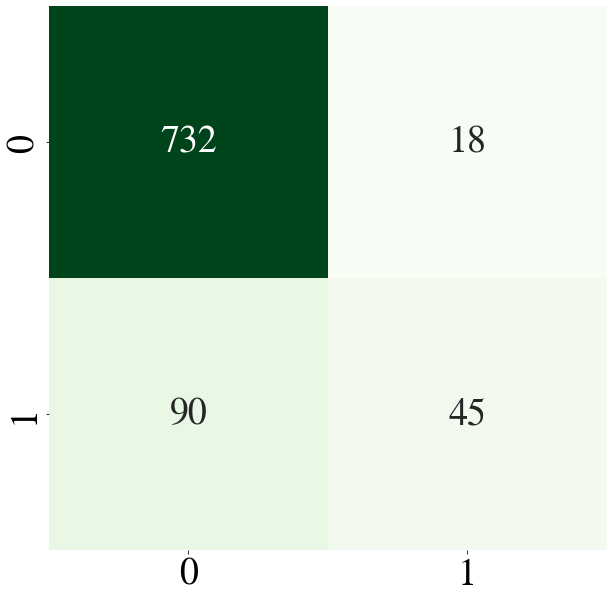

In [61]:
### Matrici di confusione

plot_confusion_matrix(y_test_paper, y_pred_paper,'paper')


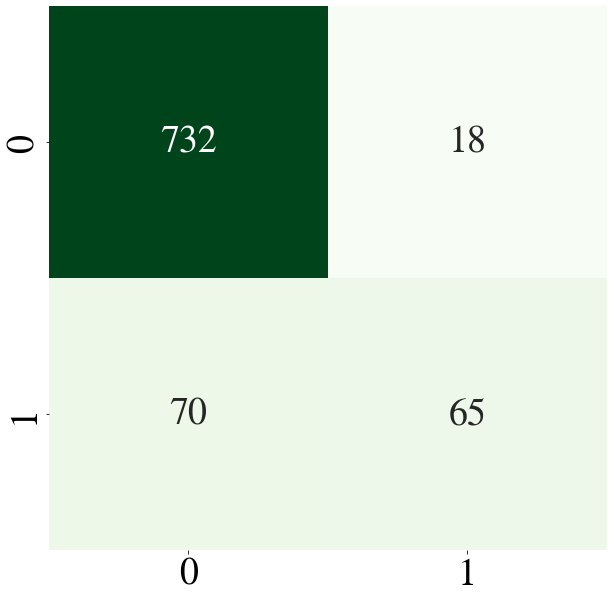

In [62]:
plot_confusion_matrix(y_test_full, y_pred_full,'full')


In [63]:
all_features = {c:0 for c in df_dataset_full.columns[1:-1]}

In [64]:
all_features = {'balance': 0,
 'lifetime': 0,
 'tx_in': 0,
 'tx_out': 0,
 'investment_in': 0,
 'payment_out': 0,
 'investment_to_contract/tx_in': 1,
 'payment_from_contract/tx_out': 1,
 '#addresses_paying_contract': 0,
 '#addresses_paid_by_contract': 0,
 'mean_v1': 0,
 'sdev_v1': 0,
 'mean_v2': 0,
 'sdev_v2': 0,
 'paid_rate': 0,
 'paid_one': 0,
 'percentage_some_tx_in': 1,
 'sdev_tx_in': 1,
 'percentage_some_tx_out': 1,
 'sdev_tx_out': 1,
 'known_rate': 0,
 'owner_gets_eth_Wo_investing': 1,
 'owner_gets_eth_investing': 1,
 'owner_no_eth': 1,
 'skew_v1': 0,
 'N_maxpayment': 0,
 'skew_v2': 0}

In [65]:
all_features_names = {'balance': 'Balance',
 'lifetime': 'Lifetime',
 'tx_in': 'Tx_in',
 'tx_out': 'Tx_out',
 'investment_in': 'Investment_in',
 'payment_out': 'Payment_out',
 'investment_to_contract/tx_in': 'Investment_in/Tx_in',
 'payment_from_contract/tx_out': 'Payment_out/Tx_out',
 '#addresses_paying_contract': '#addresses_paying_contract',
 '#addresses_paid_by_contract': '#addresses_paid_by_contract',
 'mean_v1': 'Mean_v1',
 'sdev_v1': 'Sdev_v1',
 'mean_v2': 'Mean_v2',
 'sdev_v2': 'Sdev_v2',
 'paid_rate': 'Paid_rate',
 'paid_one': 'Paid_one',
 'percentage_some_tx_in': 'Percentage_some_tx_in',
 'sdev_tx_in': 'Sdev_tx_in',
 'percentage_some_tx_out': 'Percentage_some_tx_out',
 'sdev_tx_out': 'Sdev_tx_out',
 'known_rate': 'Known_rate',
 'owner_gets_eth_Wo_investing': 'Initiator_gets_eth_Wo_investing',
 'owner_gets_eth_investing': 'Initiator_gets_eth_investing',
 'owner_no_eth': 'Initiator_no_eth',
 'skew_v1': 'Skew_v1',
 'N_maxpayment': 'N_maxpayment',
 'skew_v2': 'Skew_v2'
}

In [66]:
def clean_labels(labels):
    r_labels = []
    for l in labels:
        t = l.split('_')
        res = l
        if len(t)>2:
            res = t[0]+'_'+t[1]+'\n'+'_'.join(t[2:])
        r_labels.append(res)
    return r_labels
            

In [71]:
def plot_feature_importances(df,grid_search,name,all_features_names,only_new=False):
    if only_new:
        features_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
        feature_names = df.columns[1:-1]
        sorted_feat_imp = sorted(zip(features_importances, feature_names), reverse=False)
        print(sorted_feat_imp)

        labels = [all_features_names[n[1]] for n in sorted_feat_imp if all_features[n[1]]]
        values = [n[0] for n in sorted_feat_imp if all_features[n[1]]]

        labels = clean_labels(labels)
        print(labels)
        plt.figure(figsize=(10,7))
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.xlabel('Feature importance',fontsize=18)
        barlist = plt.barh(y=labels,width=values)
#         for i,l in enumerate(labels):
#             if all_features[l.replace('\n','_')]:
#                 barlist[i].set_color('r')
        plt.tight_layout()
        plt.savefig('feat_imp_{}.png'.format(name))
        plt.show()
        
        
    else: 
        features_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
        feature_names = df.columns[1:-1]
        sorted_feat_imp = sorted(zip(features_importances, feature_names), reverse=False)
        print(sorted_feat_imp)

        labels = [all_features_names[n[1]] for n in sorted_feat_imp[-13:]]
        values = [n[0] for n in sorted_feat_imp[-13:]]

        labels = clean_labels(labels)
        print(labels)
        plt.figure(figsize=(10,10))
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.xlabel('Feature importance',fontsize=18)
        barlist = plt.barh(y=labels,width=values)
        for i,l in enumerate(labels):
            if all_features[l.replace('\n','_')]:
                barlist[i].set_color('r')
        plt.savefig('feat_imp_{}.png'.format(name))
        plt.show()

[(10, 'owner_no_eth'), (16, 'owner_gets_eth_investing'), (27, 'payment_from_contract/tx_out'), (32, 'payment_out'), (44, 'owner_gets_eth_Wo_investing'), (51, 'tx_out'), (52, '#addresses_paying_contract'), (57, 'N_maxpayment'), (62, 'sdev_tx_out'), (71, 'investment_in'), (76, 'mean_v2'), (82, '#addresses_paid_by_contract'), (83, 'known_rate'), (104, 'paid_one'), (106, 'paid_rate'), (122, 'skew_v1'), (127, 'balance'), (141, 'skew_v2'), (149, 'percentage_some_tx_out'), (160, 'sdev_v1'), (185, 'mean_v1'), (272, 'investment_to_contract/tx_in'), (295, 'sdev_v2'), (297, 'percentage_some_tx_in'), (324, 'lifetime'), (325, 'tx_in'), (329, 'sdev_tx_in')]
['Initiator_no\neth', 'Initiator_gets\neth_investing', 'Payment_out/Tx\nout', 'Initiator_gets\neth_Wo_investing', 'Sdev_tx\nout', 'Percentage_some\ntx_out', 'Investment_in/Tx\nin', 'Percentage_some\ntx_in', 'Sdev_tx\nin']


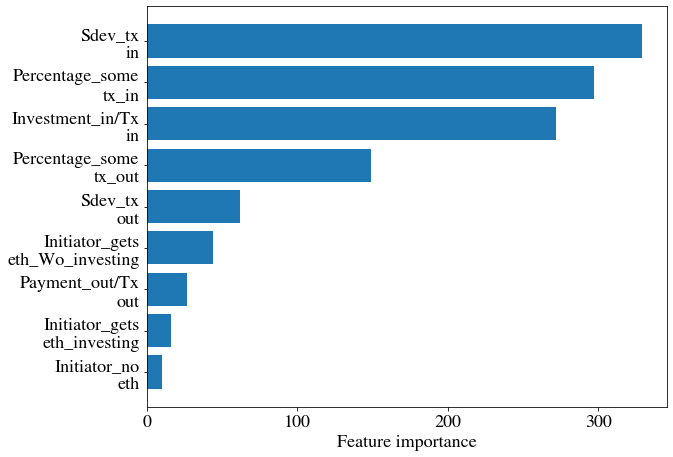

In [72]:
plot_feature_importances(df_dataset_full,grid_search_full,'full',all_features_names,only_new=True)

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full

In [80]:
cross_validations = {}

df_cross_validations = pd.DataFrame()

df_X_train_full = pd.DataFrame(X_train_full,columns=df_dataset_full.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test_full,columns=df_dataset_full.columns[1:-1])
model = grid_search_full.best_estimator_
auc_scores = {'n_features':[],'auc_score':[]}
for i in range(len(df_X_train_full.columns),10,-1):
    rfe = RFE(model,n_features_to_select=i)
    rfe = rfe.fit(df_X_train_full, y_train_full.ravel())

# summarize the selection of the attributes
#     print(rfe.support_)
#     print(rfe.ranking_)
    print(set(rfe.feature_names_in_).difference(rfe.get_feature_names_out()))
    X_train_transformed = rfe.transform(df_X_train_full)
    X_test_transformed = rfe.transform(df_X_test_full)
    
    df_X_train_full = pd.DataFrame(X_train_transformed,columns=rfe.get_feature_names_out())
    df_X_test_full = pd.DataFrame(X_test_transformed,columns=rfe.get_feature_names_out())
    
    pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

    params =[
        {
            'classifier': [DecisionTreeClassifier(random_state=42)],
            'classifier__criterion' : ['entropy', 'gini'],
            'classifier__max_depth' : [5, 6, 7, 8, 9],
            'classifier__min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
            'classifier__max_features' : range(6,X_train_transformed.shape[1],3),
            'classifier__class_weight' : [{0:1, 1:4}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
        },
        {
            'classifier': [RandomForestClassifier(random_state=42)],
            'classifier__n_estimators':[150, 175, 200, 225, 250],
            'classifier__min_samples_split' : [5,15,30],
            'classifier__criterion':['gini', 'entropy'],
            'classifier__class_weight' : [{0:1, 1:5.5}],
            'classifier__bootstrap': [True, False]
        },
    #     {
    #         'classifier': [SVC(random_state=42,probability=True)],            
    #         'classifier__kernel' : ["poly"],
    #         'classifier__C' : [0.1,1,5,10],
    #         'classifier__coef0' : [1,0.8],
    #         'classifier__gamma': ['auto']

    #     },
        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1,0.01],
            'classifier__n_estimators' : [80, 100, 120],
            'classifier__max_depth' : [10,15,20],
            'classifier__colsample_bytree' : [0.5,0.8,1],
            'classifier__reg_alpha' : [0, 0.1, 0.2],
            'classifier__reg_lambda' : [1,10,15]
        }



     ]
    grid_search = GridSearchCV(pipeline, params, cv=5,
                           scoring='roc_auc',
                           return_train_score=True,n_jobs=4)
    grid_search.fit(df_X_train_full, y_train_full.ravel())
    cross_validations[i] = grid_search 
    _tmp_cv = pd.DataFrame(grid_search.cv_results_)
    _tmp_cv['n_features'] = i
    _tmp_cv['features'] = ','.join([column for column in rfe.get_feature_names_out() ])
    
    df_cross_validations = pd.concat([df_cross_validations,_tmp_cv])
    
    model = grid_search.best_estimator_.named_steps['classifier']
    model.fit(df_X_train_full,y_train_full.ravel())
    y_pred_proba = model.predict_proba(df_X_test_full)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test_full,y_pred_proba)    
    auc_score = roc_auc_score(y_test_full,y_pred_proba)
    print(auc_score)
    auc_scores['n_features'].append(i)
    auc_scores['auc_score'].append(auc_score)

set()
0.8793580246913579
{'owner_no_eth'}
0.8879259259259258
{'owner_gets_eth_investing'}
0.8819604938271605
{'payment_out'}
0.8837876543209876
{'owner_gets_eth_Wo_investing'}
0.8839259259259259
{'payment_from_contract/tx_out'}
0.8805777777777777
{'#addresses_paying_contract'}
0.8813827160493828
{'sdev_tx_out'}
0.8836
{'N_maxpayment'}
0.8792148148148149
{'known_rate'}
0.8830814814814814
{'investment_in'}
0.8823851851851852
{'#addresses_paid_by_contract'}
0.8755950617283951
{'mean_v2'}
0.8820987654320988
{'paid_one'}
0.8793925925925926
{'tx_out'}
0.8772296296296296
{'paid_rate'}
0.8752444444444445
{'skew_v1'}
0.8793234567901235


In [81]:
df_cross_validations.sort_values('mean_test_score',ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__class_weight,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
469,0.115768,0.001564,0.003326,0.000192,"LGBMClassifier(colsample_bytree=0.5, max_depth...",NaN,NaN,15,NaN,NaN,...,1,0.973042,0.97473,0.976283,0.976277,0.973965,0.974859,0.001277,24,"balance,lifetime,tx_in,tx_out,investment_in,in..."


In [82]:
best_features_set = df_cross_validations.sort_values('mean_test_score',ascending=False).head(1)['features'].values[0]

In [83]:
best_features_set = best_features_set.split(',')

In [86]:
best_feat_cv.best_params_

{'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=120, n_jobs=4,
                random_state=42, reg_alpha=0.1, reg_lambda=10),
 'classifier__colsample_bytree': 0.5,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 15,
 'classifier__n_estimators': 120,
 'classifier__reg_alpha': 0.1,
 'classifier__reg_lambda': 10}

In [85]:
best_feat_cv = cross_validations[24]
best_feat_model = best_feat_cv.best_estimator_

In [87]:
best_features_set

['balance',
 'lifetime',
 'tx_in',
 'tx_out',
 'investment_in',
 'investment_to_contract/tx_in',
 'payment_from_contract/tx_out',
 '#addresses_paying_contract',
 '#addresses_paid_by_contract',
 'mean_v1',
 'sdev_v1',
 'mean_v2',
 'sdev_v2',
 'paid_rate',
 'paid_one',
 'percentage_some_tx_in',
 'sdev_tx_in',
 'percentage_some_tx_out',
 'sdev_tx_out',
 'known_rate',
 'owner_gets_eth_Wo_investing',
 'skew_v1',
 'N_maxpayment',
 'skew_v2']

In [103]:
df_X_train_full = pd.DataFrame(X_train_full,columns=df_dataset_full.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test_full,columns=df_dataset_full.columns[1:-1])

df_X_train_full = df_X_train_full[best_features_set].copy()
df_X_test_full = df_X_test_full[best_features_set].copy()

best_feat_model.fit(df_X_train_full,y_train_full.ravel())
y_pred_proba_best = best_feat_model.predict_proba(df_X_test_full)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_full,y_pred_proba_best)    
auc_score = roc_auc_score(y_test_full,y_pred_proba_best)


y_pred_best = best_feat_model.predict(df_X_test_full)
best_precision_test= precision_score(y_test_full, y_pred_best) # TP / (FP + TP)
best_recall_test = recall_score(y_test_full, y_pred_best)	     # TP / (FN + TP)
best_accuracy_test = accuracy_score(y_test_full, y_pred_best)	 # (TP + TN)/ (TP + FN + TN + FP)
best_f1_test = f1_score(y_test_full, y_pred_best)

print('AUC: {:.3f}'.format(auc_score))
print('Precision: {:.3f}'.format(best_precision_test))
print('Recall: {:.3f}'.format(best_recall_test))
print('Accuracy: {:.3f}'.format(best_accuracy_test))
print('F1: {:.3f}'.format(best_f1_test))



AUC: 0.884
Precision: 0.846
Recall: 0.489
Accuracy: 0.908
F1: 0.620


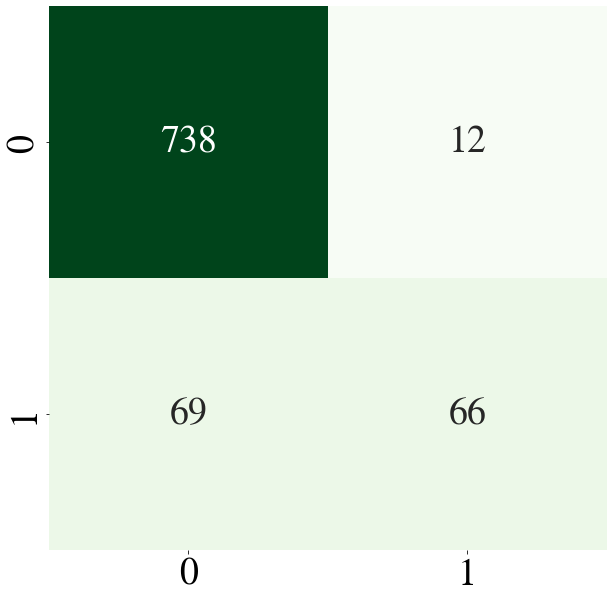

In [96]:
y_pred_best = best_feat_model.predict(df_X_test_full)
plot_confusion_matrix(y_test_full, y_pred_best,'best')


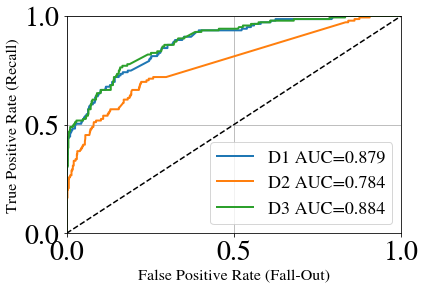

In [97]:
#### PLOTTING THE ROC CURVE OF BOTH CLASSIFIERS ON THE SAME PLOT

y_pred_paper_proba = grid_search_paper.best_estimator_.predict_proba(X_test_paper)[:, 1]
y_pred_full_proba = grid_search_full.best_estimator_.predict_proba(X_test_full)[:, 1]

fpr_paper, tpr_paper, thresholds_paper = roc_curve(y_test_paper,y_pred_paper_proba)    
auc_score_paper = roc_auc_score(y_test_paper,y_pred_paper_proba)

fpr_full, tpr_full, thresholds_full = roc_curve(y_test_full,y_pred_full_proba)    
auc_score_full = roc_auc_score(y_test_full,y_pred_full_proba)

fpr_best, tpr_best, thresholds_full = roc_curve(y_test_full,y_pred_proba_best)    
auc_score_best = roc_auc_score(y_test_full,y_pred_proba_best)


plt.plot(fpr_full, tpr_full, linewidth=2, label=r'D1 AUC={:.3f}'.format(auc_score_full))
plt.plot(fpr_paper, tpr_paper, linewidth=2, label=r'D2 AUC={:.3f}'.format(auc_score_paper))
plt.plot(fpr_best, tpr_best, linewidth=2, label=r'D3 AUC={:.3f}'.format(auc_score_best))

plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])                                    
plt.xlabel(r'False Positive Rate (Fall-Out)', fontsize=16) 
plt.ylabel(r'True Positive Rate (Recall)', fontsize=16)
plt.legend(loc='best',fontsize=18)
plt.grid(True)                                            
plt.savefig(r'comparison_roc_curve_best.png')
plt.show()





In [98]:
import pickle
pickle.dump(best_feat_model, open('best_feat_model.pkl', 'wb'))

In [99]:
df_dataset_full[['address']+best_features_set+['target']].to_csv('best_dataset.csv',index=False)